<a href="https://colab.research.google.com/github/Gorphe/Howard-Gugger-Book/blob/main/14_Resnets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from fastai.vision.all import *

GOING BACK TO IMAGENETTE

In [3]:
def get_data(url, presize, resize):
  path = untar_data(url)
  db = DataBlock(
      blocks = (ImageBlock, CategoryBlock),
      get_items=get_image_files,
      splitter=GrandparentSplitter(valid_name='val'),
      get_y=parent_label,
      item_tfms=Resize(presize),
      batch_tfms=[*aug_transforms(min_scale=0.5, size=resize), Normalize.from_stats(*imagenet_stats)]
      ).dataloaders(path, bs=128)
  return db


In [4]:
dls = get_data(URLs.IMAGENETTE_160,160,128)

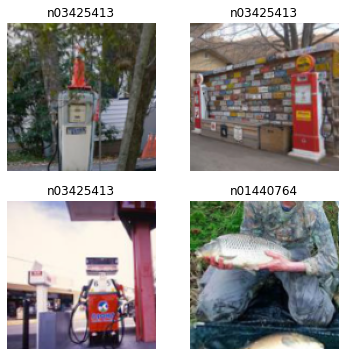

In [5]:
dls.show_batch(max_n=4)

In [6]:
def avg_pool(x):
  return x.mean((2,3))


In [7]:
def block(ni, nf):
  return ConvLayer(ni, nf, stride=2)

def get_model():
  layer=nn.Sequential(
      block(3,16),
      block(16,32),
      block(32,64),
      block(64,128),
      block(128,256),
      nn.AdaptiveAvgPool2d(1),
      Flatten(),
      nn.Linear(256, dls.c)
  )
  return layer

In [33]:
def get_learner(m):
  learner = Learner(dls, m, loss_func=nn.CrossEntropyLoss(), metrics=accuracy)
  return learner.to_fp16()

/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


SuggestedLRs(valley=0.0004786300996784121)

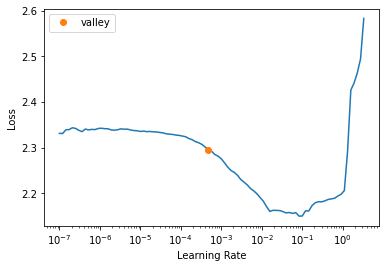

In [9]:
learn = get_learner(get_model())
learn.lr_find()

In [10]:
learn.fit_one_cycle(5,3e-3)

/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


epoch,train_loss,valid_loss,accuracy,time
0,1.893579,2.216126,0.340892,01:50
1,1.536562,1.615183,0.491465,01:50
2,1.296308,1.268457,0.597962,01:49
3,1.138978,1.094018,0.652484,01:50
4,1.049187,1.051772,0.673376,01:51


BUILDING A MODERN CNN: RESNET

In [29]:
def _conv_block(ni, nf, stride):
  return nn.Sequential (
      ConvLayer(ni, nf, stride=stride),
      ConvLayer(ni, nf, act_cls=None, norm_type=NormType.BatchZero)
  )


class ResBlock(Module):
  def __init__(self, ni, nf, stride=1):
    self.convs = _conv_block(ni, nf, stride)
    self.idconv = noop if ni==nf else ConvLayer(ni, nf, 1, act_cls=None)
    self.pool = noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)
  
  def forward(self, x):
    return F.relu(self.convs(x) +self.idconv(self.pool(x)))
  


In [30]:
def block(ni, nf):
  return nn.Sequential(ResBlock(ni, nf, stride=2), ResBlock(nf, nf))


In [31]:
learn = get_learner(get_model())

In [34]:
learn.fit_one_cycle(5, 3e-3)

/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


epoch,train_loss,valid_loss,accuracy,time


RuntimeError: ignored

A state of the art ResNet

In [36]:
def _resnet_stem(*sizes):
  return [
          ConvLayer(sizes[i], sizes[i+1], 3, stride = 2 if i==0 else 1)
              for i in range(len(sizes)-1)
  ] + [nn.MaxPool2d(kernel_size=3, stride=2, padding=1)]

_resnet_stem(3, 32, 32, 64)

[ConvLayer(
   (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
   (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ), ConvLayer(
   (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ), ConvLayer(
   (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ), MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)]

In [38]:
class ResNet(nn.Sequential):
  def __init__(self, n_out, layers, expansion=1):
    stem = _resnet_stem(3, 32, 32, 64)
    self.block_szs = [64,64,128,256,512]
    
    for i in range(1,5):
      self.block_szs[i] *= expansion
    
    blocks = [self._make_layer(*o) for o in enumerate(layers)]
    super().__init__(*stem, *blocks, nn.AdaptiveAvgPool2d(1), Flatten(), nn.Linear(self.block_szs[-1], n_out))

  def _make_layer(self, idx, n_layers):
    stride =1 if idx==0 else 2
    ch_in, ch_out = self.block_szs[idx:idx+2]

    return nn.Sequential(*[
                           ResBlock(ch_in if i==0 else ch_out, ch_out, stride if i==0 else 1)
                           for i in range(n_layers)
    ])
  

In [39]:
rn = ResNet(dls.c, [2, 2, 2, 2])

In [40]:
learn = get_learner(rn)

In [41]:
learn.fit_one_cycle(5, 3e-3)

/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


epoch,train_loss,valid_loss,accuracy,time


RuntimeError: ignored

Bottleneck layers

In [42]:
def __conv_block(ni, nf, stride):
  return nn.Sequential(
      ConvLayer(ni, nf//4, 1),
      ConvLayer(nf//4, nf//4, stride=stride),
      ConvLayer(nf//4, nf, 1, act_cls=None, norm_type=NormType.BatchZero)
  )
  

In [43]:
dls = get_data(URLs.IMAGENETTE_320, presize=320, resize=224)

In [44]:
rs=ResNet(dls.c, [3,4,6,3],4)

In [45]:
learn = get_learner(rn)

In [46]:
learn.fit_one_cycle(20,3e-3)

/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


epoch,train_loss,valid_loss,accuracy,time


RuntimeError: ignored